In [12]:
# Imports iniciales y configuración
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Estilo de gráficos
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Función para matching de países
def find_country_matches(edgar_countries, other_countries):
    matches = {}
    
    # Coincidencias exactas
    for edgar_country in edgar_countries:
        if edgar_country in other_countries:
            matches[edgar_country] = edgar_country
    
    # Mapeo manual para casos especiales
    manual_mapping = {
        'Russia': 'Russian Federation',
        'Iran': 'Iran, Islamic Rep.',
        'South Korea': 'Korea, Rep.',
        'Turkey': 'Turkiye',
        'Egypt': 'Egypt, Arab Rep.',
        'Venezuela': 'Venezuela, RB',
        'United States': 'United States',
        'China': 'China',
        'India': 'India',
        'Germany': 'Germany',
        'Japan': 'Japan',
        'United Kingdom': 'United Kingdom',
        'France': 'France',
        'Italy': 'Italy',
        'Brazil': 'Brazil',
        'Canada': 'Canada',
        'Australia': 'Australia',
        'Spain': 'Spain',
        'Mexico': 'Mexico',
        'Indonesia': 'Indonesia'
    }
    
    # Aplicar mapeo manual
    for edgar_name, other_name in manual_mapping.items():
        if edgar_name in edgar_countries and other_name in other_countries:
            matches[edgar_name] = other_name
    
    return matches

DESDARROLLO INDICES

In [13]:
# 1. Desarrollo (WDI)
wdi_path = "../../data/fuentes/economicos/P_Data_Extract_From_World_Development_Indicators.xlsx"
xls_wdi  = pd.ExcelFile(wdi_path)
df_wdi   = xls_wdi.parse("Data")

print("Dataset WDI cargado:")
print(f"Dimensiones: {df_wdi.shape}")
display(df_wdi.head())

Dataset WDI cargado:
Dimensiones: (1601, 68)


,Country Name,Country Code,Series Name,Series Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,Afghanistan,AFG,Carbon intensity of GDP (kg CO2e per 2021 PPP ...,EN.GHG.CO2.RT.GDP.PP.KD,..,..,..,..,..,..,...,0.083662,0.086847,0.077308,0.081098,0.076226,0.067211,0.050538,0.06575,0.070581,..
1,Afghanistan,AFG,Carbon intensity of GDP (kg CO2e per constant ...,EN.GHG.CO2.RT.GDP.KD,..,..,..,..,..,..,...,0.438997,0.455707,0.405653,0.425544,0.399975,0.352672,0.265188,0.345006,0.370357,..
2,Afghanistan,AFG,"Electricity production from oil, gas and coal ...",EG.ELC.FOSL.ZS,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
3,Afghanistan,AFG,"Electricity production from renewable sources,...",EG.ELC.RNWX.ZS,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
4,Afghanistan,AFG,"Electricity production from renewable sources,...",EG.ELC.RNWX.KH,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..


Primeros años detectados: [1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969] ...
Nulos por año (WDI):


1960    1205
1961    1205
1962    1205
1963    1205
1964    1205
        ... 
2019     830
2020     831
2021     832
2022     838
2023    1313
Length: 64, dtype: int64

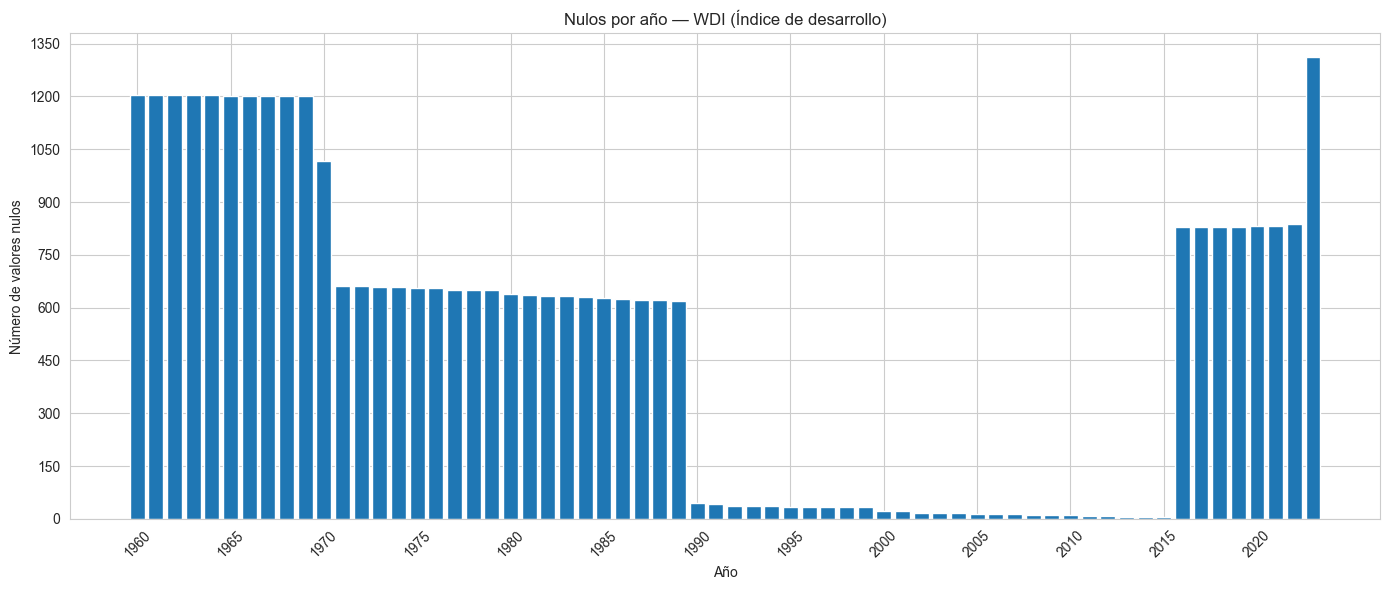

In [16]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 1) Cargar WDI: la hoja 'Data' ya tiene encabezados en la PRIMERA fila
wdi_path = "../../data/fuentes/economicos/P_Data_Extract_From_World_Development_Indicators.xlsx"
df_wdi = pd.read_excel(wdi_path, sheet_name="Data", header=0)

# 2) Detectar columnas de años con regex (soporta '1960 [YR1960]', 'YR1960', 'Y1960', etc.)
def detectar_anio(col):
    s = str(col)
    m = re.search(r'(?<!\d)(\d{4})(?!\d)', s)  # toma el primer año de 4 dígitos
    if m:
        y = int(m.group(1))
        return y if 1800 <= y <= 2100 else None
    return None

year_map = {c: detectar_anio(c) for c in df_wdi.columns}
year_map = {c: y for c, y in year_map.items() if y is not None}  # solo las que tienen año

# 3) Renombrar columnas de año a enteros (p.ej., '1960 [YR1960]' -> 1960)
df_wdi = df_wdi.rename(columns=year_map)
year_cols = sorted(set(year_map.values()))

# 4) Normalizar a numérico y limpiar filas con TODOS los años vacíos
df_wdi[year_cols] = df_wdi[year_cols].apply(pd.to_numeric, errors="coerce")
df_wdi[year_cols] = df_wdi[year_cols].replace([np.inf, -np.inf], np.nan)
mask_all_empty = df_wdi[year_cols].isna().all(axis=1)
df_wdi_clean = df_wdi.loc[~mask_all_empty].reset_index(drop=True)

# 5) Calcular nulos por año
nulos_wdi = df_wdi_clean[year_cols].isna().sum()
nulos_wdi = pd.to_numeric(nulos_wdi, errors="coerce").fillna(0).astype(int).sort_index()

print("Primeros años detectados:", year_cols[:10], "..." if len(year_cols) > 10 else "")
print("Nulos por año (WDI):")
display(nulos_wdi)

# 6) Graficar (Y solo enteros, X cada 5 años)
plt.figure(figsize=(14,6))
plt.bar(nulos_wdi.index.astype(str), nulos_wdi.values)
xt = nulos_wdi.index.astype(str)[::5] if len(nulos_wdi) > 5 else nulos_wdi.index.astype(str)
plt.xticks(xt, rotation=45)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Nulos por año — WDI (Índice de desarrollo)")
plt.xlabel("Año")
plt.ylabel("Número de valores nulos")
plt.tight_layout()
plt.show()


Años detectados: [1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989] ...
Nulos por año — Desastres naturales:


1980    1734
1981    1710
1982    1694
1983    1594
1984    1700
1985    1686
1986    1710
1987    1608
1988    1608
1989    1662
1990    1602
1991    1610
1992    1654
1993    1568
1994    1566
1995    1554
1996    1558
1997    1470
1998    1462
1999    1374
2000    1368
2001    1378
2002    1312
2003    1394
2004    1428
2005    1294
2006    1446
2007    1330
2008    1400
2009    1392
2010    1290
2011    1474
2012    1376
2013    1458
2014    1500
2015    1358
2016    1460
2017    1374
2018    1398
2019    1364
2020    1362
2021    1332
2022    1284
2023    1254
2024    1354
dtype: int64

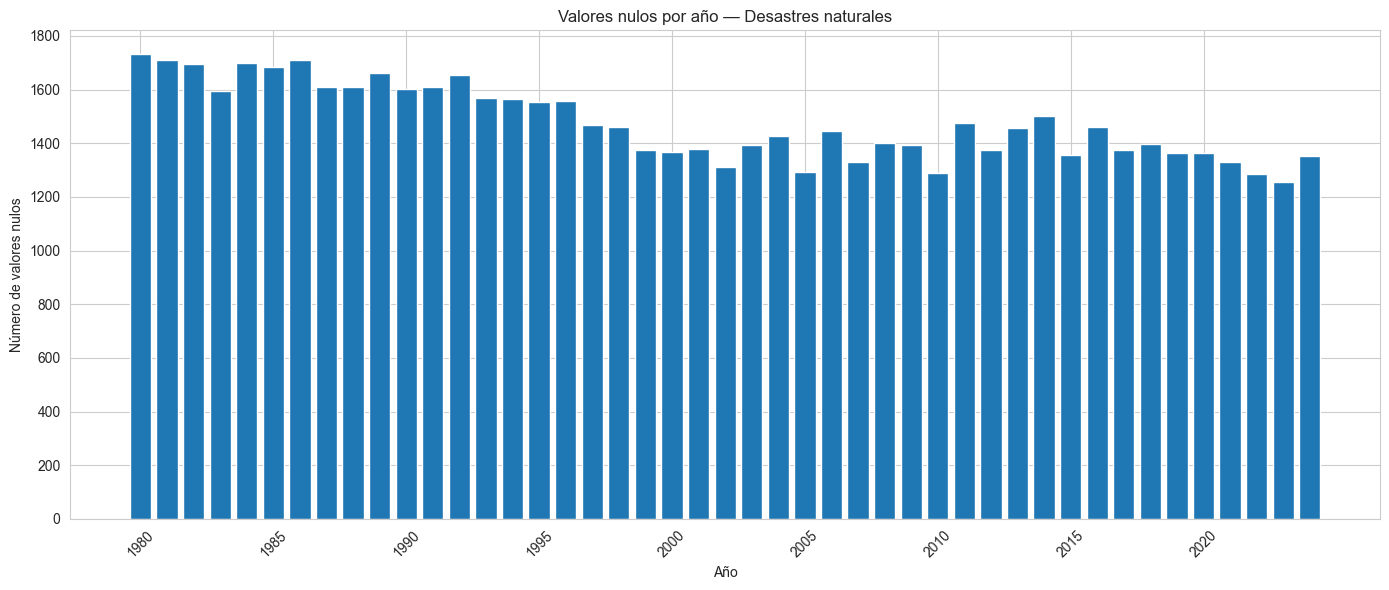

In [17]:
# =========================================================
# Nulos por año — Desastres naturales (carga completa)
# =========================================================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 1) Ruta y carga del archivo
desastres_path = "../../data/fuentes/climaticos/Indicator_11_1_Physical_Risks_Climate_related_disasters_frequency_7212563912390016675.csv"
df_des = pd.read_csv(desastres_path, encoding="utf-8")

# 2) Detectar/normalizar columnas de años
#    Soporta columnas tipo: 1980, '1980 ', 'Y1980', 'YR1980', '1980 [YR1980]'
def extraer_anio(col):
    s = str(col).strip()
    # Primero, capturamos 4 dígitos que parezcan año
    m = re.search(r'(?<!\d)(\d{4})(?!\d)', s)
    if m:
        y = int(m.group(1))
        return y if 1800 <= y <= 2100 else None
    # Fallback para 'Y1980', 'YR1980'
    m2 = re.search(r'Y?R?(\d{4})', s, flags=re.IGNORECASE)
    if m2:
        y = int(m2.group(1))
        return y if 1800 <= y <= 2100 else None
    return None

# Mapeo de columnas que contienen años -> año entero
year_map = {c: extraer_anio(c) for c in df_des.columns}
year_map = {c: y for c, y in year_map.items() if y is not None}

# Renombrar las columnas de años a enteros
df_des = df_des.rename(columns=year_map)
year_cols = sorted(set(year_map.values()))

if not year_cols:
    raise RuntimeError("No se detectaron columnas de años en el CSV de desastres. Revisa los nombres de columnas.")

# 3) Convertir a numérico los años y sanear infinitos
df_des[year_cols] = df_des[year_cols].apply(pd.to_numeric, errors="coerce")
df_des[year_cols] = df_des[year_cols].replace([np.inf, -np.inf], np.nan)

# 4) Eliminar filas con TODOS los años vacíos (evita sesgos de filas sin datos)
mask_all_empty = df_des[year_cols].isna().all(axis=1)
df_des_clean = df_des.loc[~mask_all_empty].reset_index(drop=True)

# 5) Calcular nulos por año (serie ordenada, enteros)
nulos_des = df_des_clean[year_cols].isna().sum()
nulos_des = pd.to_numeric(nulos_des, errors="coerce").fillna(0).astype(int).sort_index()

print("Años detectados:", year_cols[:10], "..." if len(year_cols) > 10 else "")
print("Nulos por año — Desastres naturales:")
display(nulos_des)

# 6) Graficar (Y en enteros, X cada 5 años)
plt.figure(figsize=(14,6))
plt.bar(nulos_des.index.astype(str), nulos_des.values)
xt = nulos_des.index.astype(str)[::5] if len(nulos_des) > 5 else nulos_des.index.astype(str)
plt.xticks(xt, rotation=45)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Valores nulos por año — Desastres naturales")
plt.xlabel("Año")
plt.ylabel("Número de valores nulos")
plt.tight_layout()
plt.show()

# (Opcional) Exportar a Excel/CSV
# nulos_des.to_excel("../../data/resultados/nulos_por_anio_desastres.xlsx", sheet_name="Nulos")
# nulos_des.to_csv("../../data/resultados/nulos_por_anio_desastres.csv", header=["nulos"], index_label="anio")


NULOS SUPERFICIE KMS POR PAOIS AÑO


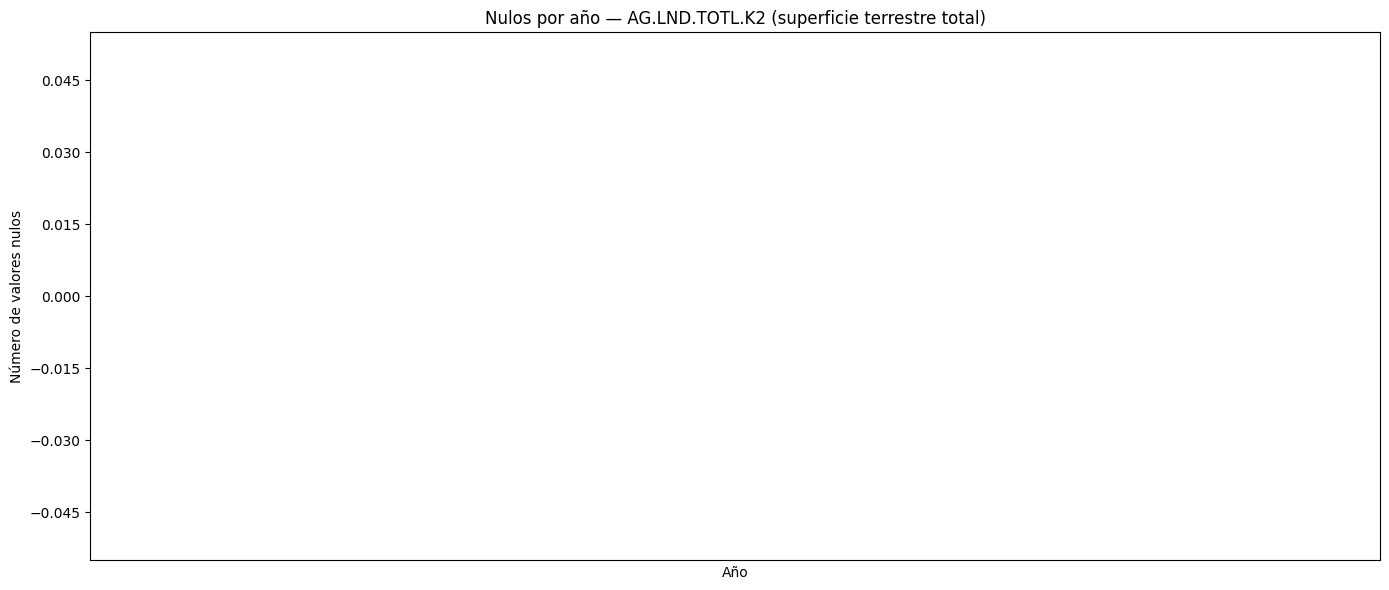

Años detectados: Index([], dtype='int64') 
Nulos por año (primeros 10):
Series([], dtype: int64)


In [5]:
# Si no tienes xlrd instalado, ejecuta antes en tu entorno:
# !pip install xlrd

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

file_path = "../../data/fuentes/demograficos/API_AG.LND.TOTL.K2_DS2_en_excel_v2_85542.xls"

# 1) Leer la hoja "Data" del archivo .xls
df = pd.read_excel(file_path, sheet_name="Data", engine="xlrd", header=0)

# 2) Detectar columnas de años con regex (soporta '1960 [YR1960]', 'YR1960', etc.)
def detectar_anio(col):
    s = str(col)
    m = re.search(r'(?<!\d)(\d{4})(?!\d)', s)  # primer año de 4 dígitos
    if m:
        y = int(m.group(1))
        return y if 1800 <= y <= 2100 else None
    return None

year_map = {c: detectar_anio(c) for c in df.columns}
year_map = {c: y for c, y in year_map.items() if y is not None}

# 3) Renombrar columnas de año a enteros
df = df.rename(columns=year_map)
year_cols = sorted(set(year_map.values()))

# 4) Convertir a numérico y limpiar filas completamente vacías
df[year_cols] = df[year_cols].apply(pd.to_numeric, errors="coerce")
df[year_cols] = df[year_cols].replace([np.inf, -np.inf], np.nan)
mask_all_empty = df[year_cols].isna().all(axis=1)
df_clean = df.loc[~mask_all_empty].reset_index(drop=True)

# 5) Calcular nulos por año
nulos_por_anio = df_clean[year_cols].isna().sum()
nulos_por_anio = pd.to_numeric(nulos_por_anio, errors="coerce").fillna(0).astype(int).sort_index()

# 6) Graficar
years = nulos_por_anio.index.astype(int)
vals  = nulos_por_anio.values

plt.figure(figsize=(14,6))
plt.bar(years, vals, color="skyblue", edgecolor="black")

# Mostrar etiquetas cada 5 años (o ajusta según prefieras)
step = 5
plt.xticks(years[::step], rotation=45)

plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Nulos por año — AG.LND.TOTL.K2 (superficie terrestre total)")
plt.xlabel("Año")
plt.ylabel("Número de valores nulos")
plt.tight_layout()
plt.show()

# Mostrar resumen
print("Años detectados:", years[:10], "..." if len(years) > 10 else "")
print("Nulos por año (primeros 10):")
print(nulos_por_anio.head(10))
